# Fetch and parse ACS benchmark results under a given directory
Each ACS benchmark run outputs a json file. This script collects all such files under a given root directory, parses them, and aggregates them into a more easily digestable pandas DataFrame.

In [1]:
import math
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

Set the local path to the root results directory:

In [2]:
RESULTS_ROOT_DIR = Path("/fast/groups/sf") / "folktexts-results" / "2024-07-03_feature-subsets"

Set the local path to the root data directory (needed only to train baseline ML methods):

In [3]:
DATA_DIR = Path("/fast/groups/sf") / "data"

Important results columns:

In [4]:
model_col = "config_model_name"
task_col = "config_task_name"

feature_subset_col = "config_feature_subset"
predictions_path_col = "predictions_path"

Helper function to parse each dictionary containing benchmark results:

In [5]:
from utils import (
    num_features_helper,
    parse_model_name,
    get_non_instruction_tuned_name,
    prettify_model_name,
)

def parse_results_dict(dct) -> dict:
    """Parses results dict and brings all information to the top-level."""

    # Make a copy so we don't modify the input object
    dct = dct.copy()

    # Discard plots' paths
    dct.pop("plots", None)

    # Bring configs to top-level
    config = dct.pop("config", {})
    for key, val in config.items():
        dct[f"config_{key}"] = val

    # Parse model name
    dct[model_col] = parse_model_name(dct[model_col])
    dct["base_name"] = get_non_instruction_tuned_name(dct[model_col])
    dct["name"] = prettify_model_name(dct[model_col])

    # Is instruction-tuned model?
    dct["is_inst"] = dct["base_name"] != dct[model_col]

    # Log number of features
    dct["num_features"] = num_features_helper(dct[feature_subset_col], max_features_return=-1)
    dct["uses_all_features"] = (dct[feature_subset_col] is None) or (dct["num_features"] == -1)

    if dct[feature_subset_col] is None:
        dct[feature_subset_col] = "full"

    # Assert all results are at the top-level
    assert not any(isinstance(val, dict) for val in dct.values())
    return dct


Iteratively search the root directory for results files matching the given regex:

In [6]:
from utils import find_files, load_json

# Results file name pattern
pattern = r'^results.bench-(?P<hash>\d+)[.]json$'

# Find results files and aggregate
results = {}
for file_path in tqdm(find_files(RESULTS_ROOT_DIR, pattern)):
    results[Path(file_path).parent.name] = parse_results_dict(load_json(file_path))

if len(results) == 0:
    raise RuntimeError(f"Couldn't find any results at {RESULTS_ROOT_DIR}")
else:
    print(f"Found {len(results)} benchmark results.")

0it [00:00, ?it/s]

Found 157 benchmark results.


Aggregate results into a single DataFrame, and generate a unique identifier for each row:

In [7]:
df = pd.DataFrame(list(results.values()))

def row_id(row) -> str:
    """Unique row identifier."""
    return f"{row[model_col]}__{row[task_col]}__{row['num_features']}"

df["id"] = df.apply(row_id, axis=1)
df = df.set_index("id", drop=True, verify_integrity=True)

print(f"{df.shape=}")
df.sample(3)

df.shape=(157, 58)


,accuracy,accuracy_diff,accuracy_ratio,balanced_accuracy,balanced_accuracy_diff,balanced_accuracy_ratio,brier_score_loss,ece,ece_quantile,equalized_odds_diff,...,config_population_filter,config_reuse_few_shot_examples,config_seed,config_task_hash,config_task_name,base_name,name,is_inst,num_features,uses_all_features
id,,,,,,,,,,,,,,,,,,,,,
gemma-2-27b-it__ACSIncome_AGEP_COW_MAR_POBP_RAC1P_RELP_SCHL_SEX_WKHP__9,0.491048,0.119364,0.777713,0.575408,0.060358,0.902716,0.414866,0.411672,0.411800,0.177953,...,None,False,42,1712803600,ACSIncome_AGEP_COW_MAR_POBP_RAC1P_RELP_SCHL_SE...,gemma-2-27b,Gemma 2 27B (it),True,9,False
Mixtral-8x7B-Instruct-v0.1__ACSIncome_AGEP_COW_MAR_POBP_RAC1P_RELP_SCHL_SEX_WKHP__9,0.762529,0.088772,0.894011,0.731414,0.230983,0.689514,0.195928,0.166547,0.166019,0.632973,...,None,False,42,1712803600,ACSIncome_AGEP_COW_MAR_POBP_RAC1P_RELP_SCHL_SE...,Mixtral-8x7B-v0.1,Mixtral 8x7B (it),True,9,False
gemma-2-27b-it__ACSIncome_COW_POBP_RAC1P__3,0.395482,0.307732,0.479565,0.505805,0.100457,0.825430,0.509275,0.505391,0.498477,0.618846,...,None,False,42,789274827,ACSIncome_COW_POBP_RAC1P,gemma-2-27b,Gemma 2 27B (it),True,3,False


Drop potential duplicates:

In [8]:
parsed_df = df.drop_duplicates(subset=["name", "is_inst", "num_features", task_col])
if len(parsed_df) != len(df):
    print(f"Found {len(df) - len(parsed_df)} duplicates! dropping rows...")
    df = parsed_df

Load scores DFs and analyze score distribution:

In [9]:
def load_model_scores_df(df_row: pd.Series) -> pd.DataFrame:
    """Loads csv containing model scores corresponding to the given DF row."""
    if predictions_path_col in df_row and not pd.isna(df_row[predictions_path_col]):
        return pd.read_csv(df_row[predictions_path_col], index_col=0)
    return None

In [10]:
scores_df_map = {
    id_: load_model_scores_df(row)
    for id_, row in tqdm(parsed_df.iterrows(), total=len(parsed_df))
}

  0%|          | 0/157 [00:00<?, ?it/s]

In [11]:
from folktexts.evaluation import compute_best_threshold
from sklearn import metrics
from scipy import stats

# Number of samples used to fit the one-parameter binarization threshold!
N = 100

fit_thresh_col = f"fit_thresh_on_{N}"
fit_acc_col = f"fit_thresh_accuracy"

optimal_thres_col = "optimal_thresh"
optimal_acc_col = "optimal_thresh_accuracy"

score_stdev_col = "score_stdev"
score_mean_col = "score_mean"

scores_stats = dict()
for row_id, row in tqdm(df.iterrows(), total=len(df)):

    # Load model scores
    scores_df = scores_df_map[row_id]
    if scores_df is None:
        logging.error(f"Couldn't find scores for {row_id}")

    # Extract scores and labels
    risk_scores = scores_df["risk_score"].to_numpy()
    labels = scores_df["label"].to_numpy()

    # Sample N rows to fit threshold
    scores_df_sample = scores_df.sample(n=N, random_state=42)

    # Compute optimal threshold on each data sample
    fit_thr = compute_best_threshold(y_true=scores_df_sample["label"], y_pred_scores=scores_df_sample["risk_score"])
    opt_thr = compute_best_threshold(y_true=labels, y_pred_scores=risk_scores)

    # Evaluate accuracy
    fit_acc = metrics.accuracy_score(labels, (risk_scores >= fit_thr).astype(int))
    opt_acc = metrics.accuracy_score(labels, (risk_scores >= opt_thr).astype(int))

    # Save results
    scores_stats[row_id] = {
        fit_thresh_col: fit_thr,
        fit_acc_col: fit_acc,
        optimal_thres_col: opt_thr,
        optimal_acc_col: opt_acc,
        score_stdev_col: np.std(risk_scores),
        score_mean_col: np.mean(risk_scores),
    }

  0%|          | 0/157 [00:00<?, ?it/s]

Update results DF with scores statistics:

In [12]:
scores_stats_df = pd.DataFrame(scores_stats.values(), index=list(scores_stats.keys()))

results_df = pd.concat((df, scores_stats_df), axis="columns")
results_df.sample(2)

,accuracy,accuracy_diff,accuracy_ratio,balanced_accuracy,balanced_accuracy_diff,balanced_accuracy_ratio,brier_score_loss,ece,ece_quantile,equalized_odds_diff,...,name,is_inst,num_features,uses_all_features,fit_thresh_on_100,fit_thresh_accuracy,optimal_thresh,optimal_thresh_accuracy,score_stdev,score_mean
Mixtral-8x7B-v0.1__ACSIncome_AGEP_COW_MAR_OCCP_POBP_RAC1P_RELP_SCHL_SEX_WKHP__10,0.648297,0.248729,0.702738,0.524920,0.043200,0.920471,0.204540,0.179335,0.184859,0.095565,...,Mixtral 8x7B,False,10,False,0.407264,0.761766,0.377347,0.729012,0.060043,0.366800
gemma-2-9b-it__ACSIncome_COW_POBP_RAC1P__3,0.466807,0.321693,0.531647,0.528798,0.084215,0.850181,0.493267,0.489119,0.475899,0.672582,...,Gemma 2 9B (it),True,3,False,0.977018,0.523376,0.939886,0.504770,0.404412,0.717929


Check if any results are missing:

In [13]:
print(results_df.groupby([model_col])[task_col].count())

config_model_name
Meta-Llama-3-70B                5
Meta-Llama-3-70B-Instruct       3
Meta-Llama-3-8B                10
Meta-Llama-3-8B-Instruct       10
Mistral-7B-Instruct-v0.2       10
Mistral-7B-v0.1                10
Mixtral-8x22B-Instruct-v0.1     1
Mixtral-8x22B-v0.1              3
Mixtral-8x7B-Instruct-v0.1      4
Mixtral-8x7B-v0.1               7
Yi-34B                         10
Yi-34B-Chat                    10
gemma-1.1-2b-it                10
gemma-1.1-7b-it                10
gemma-2-27b                     8
gemma-2-27b-it                  6
gemma-2-9b                     10
gemma-2-9b-it                  10
gemma-2b                       10
gemma-7b                       10
Name: config_task_name, dtype: int64


Finally, save results DF to the results root directory:

In [14]:
from utils import get_current_timestamp
results_df.to_csv(Path(RESULTS_ROOT_DIR) / f"aggregated_results.{get_current_timestamp()}.csv")

---
# Plots

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", rc={"grid.linestyle": "--"})
plt.rc("figure", figsize=(4.5, 3.5), dpi=200)

palette_name = "tab10"   # "colorblind"
palette = sns.color_palette(palette_name)
sns.set_palette(palette_name)
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [16]:
IMGS_DIR = RESULTS_ROOT_DIR / "imgs"
IMGS_DIR.mkdir(exist_ok=True)

def save_fig(fig, name):
    fig.savefig((IMGS_DIR / name).with_suffix(".pdf"), bbox_inches="tight")

## Score distributions of an example model with increasing evidence
Score distribution should get more discriminative (less Gaussian-shaped) with increasing evidence.,

In [22]:
# EXAMPLE_MODEL = "Meta-Llama-3-70B-Instruct"
# EXAMPLE_MODEL = "Meta-Llama-3-70B"
# EXAMPLE_MODEL = "Mistral-7B-v0.1"
# EXAMPLE_MODEL = "Mistral-7B-Instruct-v0.2"
# EXAMPLE_MODEL = "Yi-34B-Chat"
# EXAMPLE_MODEL = "Meta-Llama-3-8B"
EXAMPLE_MODEL = "Meta-Llama-3-8B-Instruct"

**TODO?** plot xgboost score distribution as features are added! to show below the LLM score distribution as what true uncertainty quantification looks like...

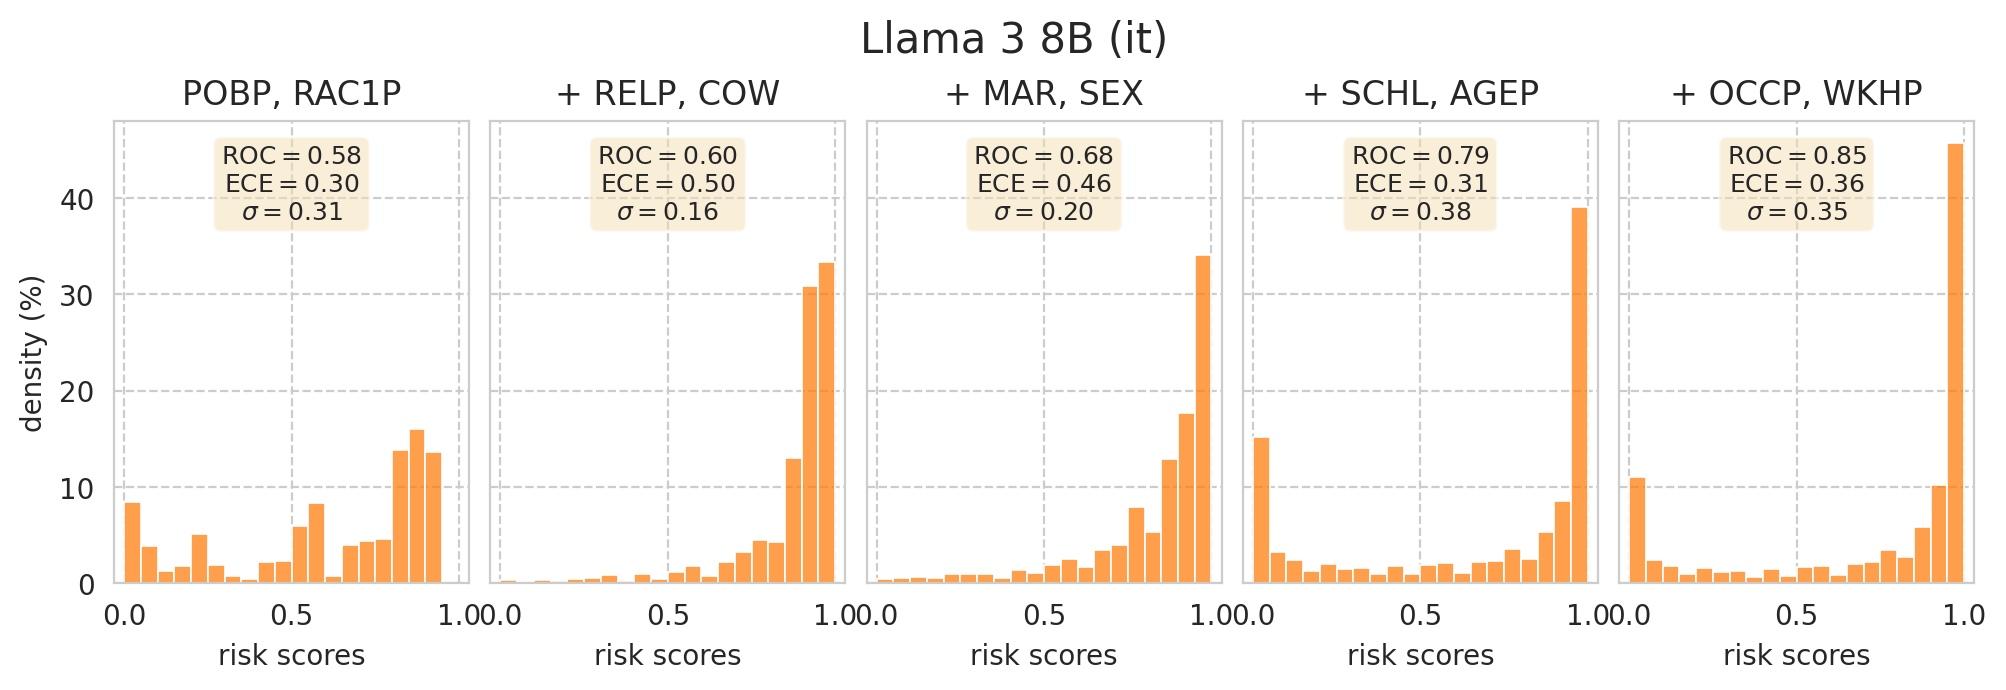

In [23]:
# Get data to plot
plot_df = results_df[results_df[model_col] == EXAMPLE_MODEL].sort_values("num_features")
# Skip every other row in plot
plot_df = plot_df[[idx % 2 == 1 for idx in range(len(plot_df))]]

# # For current Llama-3-8B-Instruct results
# plot_df = plot_df[[False, True, False, True, True, False, True]]

N_PLOTS = min(10, len(plot_df))

N_COLS = 5
N_ROWS = math.ceil(N_PLOTS / N_COLS)

fig, axes = plt.subplots(
    nrows=N_ROWS, ncols=N_COLS,
    figsize=(12, 3 * N_ROWS),
    sharey=True, sharex=False,
    gridspec_kw=dict(
        hspace=0.5,
        wspace=0.06,
    ),
)

# Plot settings
plot_config = dict(
    bins=(N_BINS := 20),
    binrange=(0, 1),
    stat="percent",
)

# Plot score distribution for model pairs
current_featureset = set()

for idx, (id_, row) in enumerate(plot_df.iterrows()):
    ax_row = idx // N_COLS
    ax_col = idx % N_COLS

    ax = axes[ax_row, ax_col] if N_ROWS > 1 else axes[ax_col]

    # Get scores
    scores = scores_df_map[row.name]["risk_score"]

    # Added features
    added_features = set(row["config_feature_subset"]) - current_featureset

    # Set title with added features compared to last plot
    title_str = "+ " if len(current_featureset) > 0 else ""
    title_str += ", ".join(added_features)
    current_featureset |= added_features

    ax.set_title(title_str)

    ax.set_xlabel("risk scores")
    if ax_col == 0:
        ax.set_ylabel("density (%)")

    ax.set_xlim(-0.03, 1.03)

    # Render plot
    sns.histplot(scores, ax=ax, color=palette[1 if row["is_inst"] else 0], **plot_config)

    # Add text box with distribution stats
    textstr = '\n'.join([
        r"$\text{ROC}=%.2f$" % (row["roc_auc"],),
        r"$\text{ECE}=%.2f$" % (row["ece"],),
        r"$\sigma=%.2f$" % (row["score_stdev"],),
    ])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    if row["is_inst"]:
        # Center-aligned text box
        ax.text(0.5, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='center', bbox=props)
    else:
        # Left-aligned text box
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=props)

# Remove unused axes
[
    (axes[N_ROWS - 1, idx] if N_ROWS > 1 else axes[idx]).remove()
    for idx in range(N_COLS-1, len(plot_df) - N_COLS * (N_ROWS - 1) - 1, -1)
];

# Set suptitle
plt.suptitle(plot_df["name"].iloc[0], y=1.05, fontsize=15)

plt.plot()

save_fig(fig, f"increasing-evidence.{EXAMPLE_MODEL}.pdf")